#  🤗 Transformers

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* https://huggingface.co/docs/transformers/index
* https://huggingface.co/docs/transformers/main_classes/pipelines#transformers.pipeline.task
* https://huggingface.co/docs/transformers/preprocessing
* https://habr.com/ru/articles/704592/
* https://lightning.ai/docs/torchmetrics/stable/text/bleu_score.html

## Задачи для совместного разбора

1\. Обсудите основные возможности и экосистему пакета 🤗 Transformers на примере задачи поиска ответа на вопрос в тексте.

In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
text = '''The seminars on Deep Learning and Natural Language Processing were truly captivating,
providing a deep dive into the intricacies of these disciplines.
The wealth of knowledge and insights gained during the sessions was commendable.
However, it's disheartening to note the scarcity of homework assignments.
Anastasia, in particular, is quite concerned that the limited number of assignments might
fall short of even reaching 30. While the seminars were intellectually stimulating,
the desire for more hands-on practice through assignments remains strong,
as it is crucial for reinforcing the theoretical understanding acquired during the classes.'''

In [3]:
question1 = 'What would be the ideal number of homework assignments for Anastasia'
question2 = 'What are the shortcomings of the course?'

In [4]:
from transformers import pipeline

In [5]:
answerer = pipeline(
    'question-answering',
    model='distilbert/distilbert-base-uncased-distilled-squad'
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [6]:
answerer(question=question1, context=text)

{'score': 0.8874244689941406, 'start': 424, 'end': 426, 'answer': '30'}

In [7]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer
import torch

In [8]:
model_name = 'distilbert/distilbert-base-uncased-distilled-squad'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
inputs = tokenizer(question1, text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  2054,  2052,  2022,  1996,  7812,  2193,  1997, 19453, 14799,
          2005, 19447,   102,  1996, 17239,  2006,  2784,  4083,  1998,  3019,
          2653,  6364,  2020,  5621, 14408, 17441,  1010,  4346,  1037,  2784,
         11529,  2046,  1996, 20014, 14735,  9243,  1997,  2122, 12736,  1012,
          1996,  7177,  1997,  3716,  1998, 20062,  4227,  2076,  1996,  6521,
          2001,  4012,  3549, 20782,  1012,  2174,  1010,  2009,  1005,  1055,
          9841, 14644,  6528,  2075,  2000,  3602,  1996, 11228, 12972,  1997,
         19453, 14799,  1012, 19447,  1010,  1999,  3327,  1010,  2003,  3243,
          4986,  2008,  1996,  3132,  2193,  1997, 14799,  2453,  2991,  2460,
          1997,  2130,  4285,  2382,  1012,  2096,  1996, 17239,  2020,  7789,
          2135, 27295,  1010,  1996,  4792,  2005,  2062,  2398,  1011,  2006,
          3218,  2083, 14799,  3464,  2844,  1010,  2004,  2009,  2003, 10232,
          2005, 27788, 29278,  6129,  

In [10]:
with torch.no_grad():
    outputs = model(**inputs)

In [11]:
ans_start = outputs.start_logits.argmax()
ans_end = outputs.end_logits.argmax()
ans_end

tensor(93)

In [12]:
token_ids = inputs['input_ids'][0][ans_start:ans_end+1]
tokens = tokenizer.convert_ids_to_tokens(token_ids)
tokenizer.convert_tokens_to_string(tokens)

'30'

## Задачи для самостоятельного решения

<p class='task' id='1'></p>

1\. Среди предобученных моделей найдите модель для перевода текста с русского языка на английский. Протестируйте данную модель на нескольких предложениях, используя `transformers.pipeline`. Выведите результаты работы в следующем виде:

```
sentence1_ru -> sentence1_en
sentence2_ru -> sentence2_en
```

Получите перевод для всех текстов из файла `RuBQ_2.0_test.json` и посчитайте BLEU-score.

- [ ] Проверено на семинаре

In [13]:
import json

with open('./../data/RuBQ_2.0_test.json', 'r') as f:
    data = json.load(f)

In [14]:
ix = 0
data[ix]['question_text'], data[ix]['question_eng']

('Какой стране принадлежит знаменитый остров Пасхи?',
 'Which country does the famous Easter island belong to?')

In [15]:
from transformers import pipeline

pipe = pipeline('translation', model='Helsinki-NLP/opus-mt-ru-en', device='cpu')

In [16]:
import numpy as np

for i in np.random.randint(0, len(data), 3):
    answer = pipe(data[i]['question_text'])[0]['translation_text']
    print(f'{data[i]['question_text']} -> {answer}')

Кто брат Селены? -> Who's Selena's brother?
Кто был подлинным изобретателем телефона? -> Who was the real phone inventor?
В каком государстве Южной Америки находится озеро-залив Маракайбо? -> Which state of South America is the Lake Bay of Maracaibo?


In [17]:
from tqdm import tqdm

translated_texts = [pipe(i['question_text'])[0]['translation_text'] for i in tqdm(data)]
english_texts = [i['question_eng'] for i in tqdm(data)]
translated_texts[:2]

100%|██████████| 580/580 [00:00<00:00, 820470.93it/s]


['Which country does the famous Easter Island belong to?',
 "What kind of music group is Mick Jagger's name inextricably linked?"]

In [18]:
from torchmetrics.text import BLEUScore

metric = BLEUScore()
score = metric(english_texts, [translated_texts])
print(f'BLEU Score: {score:.6f}')

BLEU Score: 0.680375


<p class='task' id='2'></p>

2\. Среди предобученных моделей найдите модель для классификации фотографий людей по полу.

Протестируйте данную модель на нескольких фотографиях, используя `AutoFeatureExtractor` и `AutoModelForImageClassification`.

Выведите на экран сетку 2х2 из изображений, где над каждым изображением добавлена подпись, содержащая прогноз модели и правильный ответ.

- [ ] Проверено на семинаре

In [19]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

processor = AutoFeatureExtractor.from_pretrained('rizvandwiki/gender-classification')
model = AutoModelForImageClassification.from_pretrained('rizvandwiki/gender-classification')
id2label = {0: 'female', 1: 'male'}
label2id = {v: k for k, v in id2label.items()}

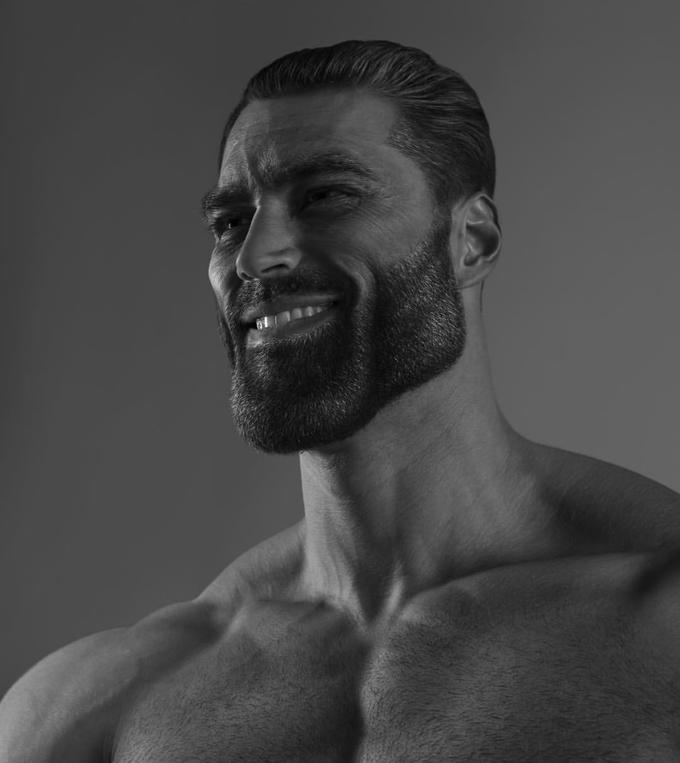

In [20]:
import requests as req
from PIL import Image

gigachad_link = 'https://upload.wikimedia.org/wikipedia/ru/9/94/Гигачад.jpg'
image = Image.open(req.get(gigachad_link, stream=True).raw).convert('RGB')
image

In [21]:
import torch as th

with th.no_grad():
    inputs = processor(image, return_tensors='pt')
    outputs = model(**inputs)
image_class_pred = outputs.logits.argmax().item()
id2label[image_class_pred]

'male'

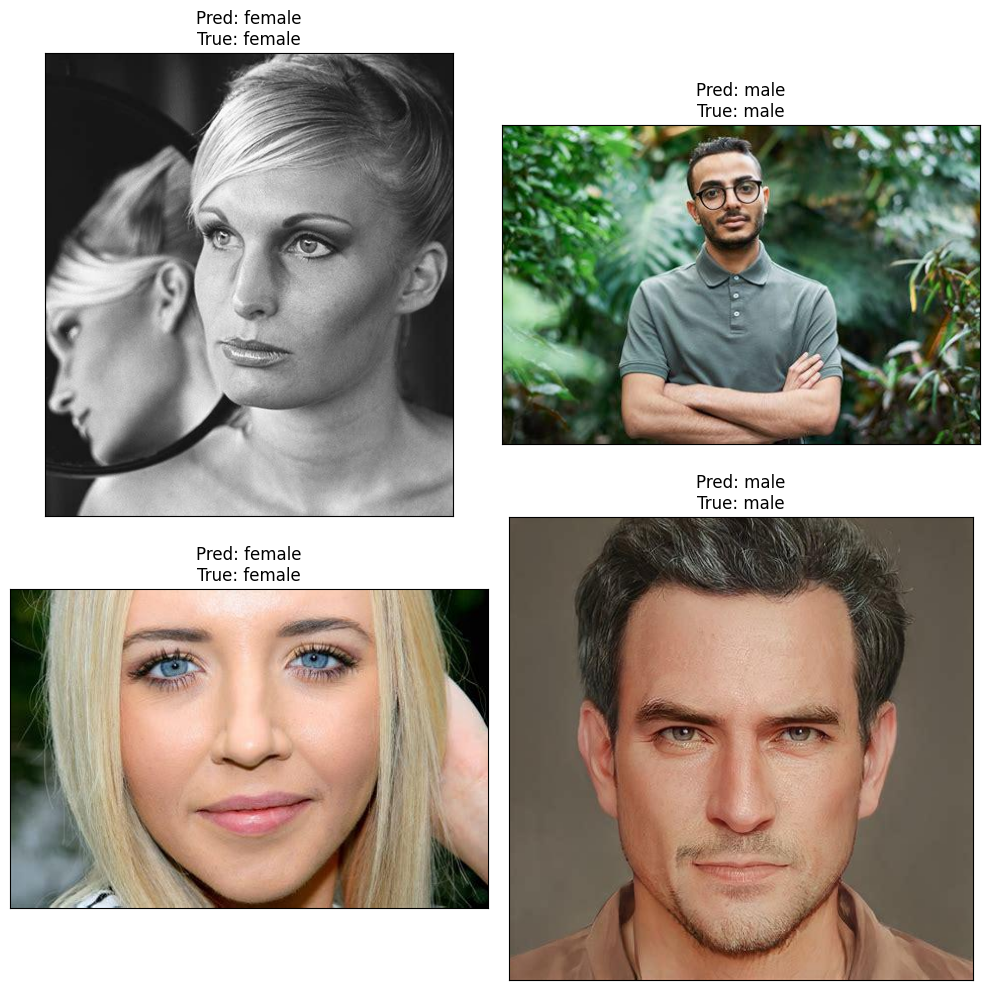

In [22]:
from matplotlib import pyplot as plt

links = {
    'https://cdn-lfs.hf.co/repos/d1/97/d1977aabf1da449ea968dea0a790b061ab27d28947718c0ac00b56295feebf7f/7c5095faa4f6589241ecafb42e7ec0178776e510b6afe533e23d86e8dcf6b733?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27female.jpg%3B+filename%3D%22female.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1731873049&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTg3MzA0OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kMS85Ny9kMTk3N2FhYmYxZGE0NDllYTk2OGRlYTBhNzkwYjA2MWFiMjdkMjg5NDc3MThjMGFjMDBiNTYyOTVmZWViZjdmLzdjNTA5NWZhYTRmNjU4OTI0MWVjYWZiNDJlN2VjMDE3ODc3NmU1MTBiNmFmZTUzM2UyM2Q4NmU4ZGNmNmI3MzM~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=KIohq33Fe595xoUtyDemzDBeiLvZdEgQ035Pa8CqXBZ7DrVuKpoC-c83xFdMw0suf8FVKGZpBEPDRPj7GosqLVB2zbmzYHbBBqSl8izfNTbXNngtI9O-COsnROh7Qy3BTls9LAn-Z4921idtF-Z122xn9QyxkAEYtfOxTxvJ5SWhBUxsRzK3ORa7NbETcA-51hUFT72YnlVdJ92LYrswnZkwiYVCZjhewu1MSqDaoptjebz2Dc~cDNEJZURC7wmw2BYw0mL-Ws2qMPuRh2VIMJc1Lv5el6x9dJThARh4oGC0cwhczgymeJqNAZLYVbe0ZIVzVg6JrtXluOiabYm5mg__&Key-Pair-Id=K3RPWS32NSSJCE': 0,
    'https://cdn-lfs.hf.co/repos/d1/97/d1977aabf1da449ea968dea0a790b061ab27d28947718c0ac00b56295feebf7f/802366c93c74e84e7eff1d6b676c2cd5c6a9e2c34907556959ebff7356996e52?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27male.jpg%3B+filename%3D%22male.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1731873061&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTg3MzA2MX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kMS85Ny9kMTk3N2FhYmYxZGE0NDllYTk2OGRlYTBhNzkwYjA2MWFiMjdkMjg5NDc3MThjMGFjMDBiNTYyOTVmZWViZjdmLzgwMjM2NmM5M2M3NGU4NGU3ZWZmMWQ2YjY3NmMyY2Q1YzZhOWUyYzM0OTA3NTU2OTU5ZWJmZjczNTY5OTZlNTI~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=haqsdEGKSjhVF8PrXvwiS8gIAvPtN5VI6z5OiqPAlTjgneZ0ZPCPisk6bwZqmXGCGcz5-alVpD0I5~xUQGi5D972QkYrLb0tAw-FVSmGMxBkJnPZ75kDARpzBlXo50D32LbHPqkK1qT4bReoearimHgwlP9xWI6g5TP5-AcI5pykfP3pmSJmnZuRAmdRKtlpBFkNlitqT9HiqT7VHv8DBrC45nYubUASJl~i-Bu3XoZ5a0crj2mu5zXHfQFZaVsuXtTKVj3Qn-PBkW86HpZWb5TB5HL4poofAFMEjjaNaj0zVaMPRybSzwyRNzwzDhx5zdg5deDnErNbRQFpD7n9lw__&Key-Pair-Id=K3RPWS32NSSJCE': 1,
    'https://cdn-lfs.hf.co/repos/d9/12/d9124b3249f10dbcd309d8f27dc5950d49d474f4c77efbcf206a0c723934ad06/9532c1eac299ee3a56b8af4a62d640523068de7f4b087cc12fed7b9ae484a840?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27female.jpg%3B+filename%3D%22female.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1731873070&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTg3MzA3MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kOS8xMi9kOTEyNGIzMjQ5ZjEwZGJjZDMwOWQ4ZjI3ZGM1OTUwZDQ5ZDQ3NGY0Yzc3ZWZiY2YyMDZhMGM3MjM5MzRhZDA2Lzk1MzJjMWVhYzI5OWVlM2E1NmI4YWY0YTYyZDY0MDUyMzA2OGRlN2Y0YjA4N2NjMTJmZWQ3YjlhZTQ4NGE4NDA~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=G2p3XpEGmkmSzhk2DhdIPFr5uSyj9osow73ZkRi2xXKfLCMRqOVQ06RA6Gx3ZcJKPIS6fkq8Jt017fG14oDROd8UpiNM4NmfyeSMgly7eICqAiPBdVF5eHV4C-p6BuVI2GG4yOjJC~gm0t0ODBWVmbUkbqchyC~SRalpnaAPwfCnhMdW7eCWHKU1idbtBk-YoxKKvkAO3bakneS1CMmFQkQ4d33op4ocBYQnwCZZYm591tSrdolIrKJX6RmN914vRfRn5N3ZMnc1-HB~VUVYLB3VzL3UR~yBcKfT1Ddv9ziwb40CsCxTi0i1swHmPZk-Rv6Gcq5sQgJ~L5LJ1Y01Tw__&Key-Pair-Id=K3RPWS32NSSJCE': 0,
    'https://cdn-lfs.hf.co/repos/d9/12/d9124b3249f10dbcd309d8f27dc5950d49d474f4c77efbcf206a0c723934ad06/fd9bfbd3dec8e55196cabb5ce8303b2ebd08a5fcaf5d4198fef9d23ea9254cc2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27male.jpg%3B+filename%3D%22male.jpg%22%3B&response-content-type=image%2Fjpeg&Expires=1731873080&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMTg3MzA4MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy9kOS8xMi9kOTEyNGIzMjQ5ZjEwZGJjZDMwOWQ4ZjI3ZGM1OTUwZDQ5ZDQ3NGY0Yzc3ZWZiY2YyMDZhMGM3MjM5MzRhZDA2L2ZkOWJmYmQzZGVjOGU1NTE5NmNhYmI1Y2U4MzAzYjJlYmQwOGE1ZmNhZjVkNDE5OGZlZjlkMjNlYTkyNTRjYzI~cmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qJnJlc3BvbnNlLWNvbnRlbnQtdHlwZT0qIn1dfQ__&Signature=qPlDp4p3152FmEwLXM0X6FZcG8OShfBrKdx80hDDrx0WuMvnLJ0z6IdQGT4P57l0h0ZXxdKnwfSyBk04DYdcCqKnLY0tMcAy1tNEyjqfWugKRJ1RBdf67b4gHW~pLL67AD5o~Zrbx26TLWUvdWPtcWch1O0nJ21P2RpHQ~5gIba3eRXqmMW-Gzm31hpvvwLGe4BTCMHFehz9kUK8vj7PQk4bUu3qVOBRnODOs0Q1EmYm41Kc91ZiBviHj8IjX9GMkWImNnOKSbOYxN72Gm0v3ukfJUHaRCiBlT5vztUoUBoEedZYDNk7p0qnwFUjwDxdV6wdn4CulqDyppHp5LlnQQ__&Key-Pair-Id=K3RPWS32NSSJCE': 1
}

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
with th.no_grad():
    for i, (image_link, image_class) in enumerate(links.items()):
        image = Image.open(req.get(image_link, stream=True).raw)
        inputs = processor(image, return_tensors='pt')
        outputs = model(**inputs)
        image_class_pred = outputs.logits.argmax().item()

        ax[i//2, i%2].imshow(image)
        ax[i//2, i%2].set_title(f'Pred: {id2label[image_class_pred]}\nTrue: {id2label[image_class]}')
        ax[i//2, i%2].set_xticks([])
        ax[i//2, i%2].set_yticks([])
plt.tight_layout()
plt.show()

<p class='task' id='3'></p>

3\. Среди предобученных моделей найдите модель для генерации аудио по тексту. Используя [данный сервис](https://geek-jokes.sameerkumar.website/api?format=json), получите текст случайной шутки. Сгенерируйте аудио с озвучкой данной шутки.

Для прослушивания полученного аудио воспользуйтесь встроенным виджетом `IPython.display.Audio`

- [ ] Проверено на семинаре

In [23]:
pipe = pipeline('text-to-speech', model='suno/bark-small')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [35]:
result = req.get('https://geek-jokes.sameerkumar.website/api?format=json', json=True)
joke = result.json().get('joke', 'No joke :(')
joke

"Chuck Norris can't finish a 'color by numbers' because his markers are filled with the blood of his victims. Unfortunately, all blood is dark red."

In [36]:
outputs = pipe(joke)
outputs

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


{'audio': array([[ 0.00451779,  0.00409759,  0.00288427, ..., -0.00165723,
         -0.00084939, -0.00126598]], dtype=float32),
 'sampling_rate': 24000}

In [37]:
from IPython.display import Audio

audio = Audio(outputs.get('audio'), rate=outputs.get('sampling_rate'))
audio

<p class='task' id='4'></p>

4\. Разработайте решение для поиска ответа на голосовой вопрос по тексту, используя готовые модели `transformers`. Решение должно включать себя следующие модели:
- модель распознавания текста из аудио;
- модель поиска ответа на вопрос в тексте;
- модель генерации аудио по тексту.

В качестве входных данных запишите небольшой аудиофрагмент в формате на русском языке. Для записи вы можете воспользоваться любым устройством: мобильным телефоном, веб-приложением (например, [этим](https://vocalremover.org/ru/voice-recorder)) и т.д.

В качестве контекста для поиска ответа используйте предложенный текст.

Продемонстируйте все промежуточные результаты, полученные в процессе работы конвейера моделей.

- [ ] Проверено на семинаре

In [38]:
text = '''
Машинное обучение — это раздел искусственного интеллекта, который позволяет компьютерным системам улучшать свою работу на основе опыта без явного программирования.
Основная идея заключается в том, что алгоритмы могут учиться на данных, выявляя закономерности и принимая решения с минимальным вмешательством человека.
Существует несколько типов машинного обучения: обучение с учителем, где алгоритм учится на размеченных данных; обучение без учителя, работающее с неразмеченными данными;
и обучение с подкреплением, где алгоритм учится через взаимодействие с окружающей средой.
'''

In [39]:
Audio('question.mp3')

In [40]:
asr_model = pipeline('automatic-speech-recognition', model='openai/whisper-tiny')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [41]:
outputs = asr_model('question.mp3')
question_text = outputs.get('text', '').strip()
question_text

'Что такое обучение безучителя?'

In [42]:
qa_model = pipeline('question-answering', model='AlexKay/xlm-roberta-large-qa-multilingual-finedtuned-ru')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [43]:
outputs = qa_model(question=question_text, context=text)
question_answer = outputs.get('answer', '').strip()
question_answer

'работающее с неразмеченными данными;'

In [44]:
tts_model = pipeline('text-to-speech', model='suno/bark-small')

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [46]:
outputs = tts_model(question_answer)
audio = Audio(outputs.get('audio'), rate=outputs.get('sampling_rate'))
audio

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
